In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import dirichlet
from pathlib import Path
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Load and transform data

In [2]:
#noshow 
columns_to_use = ["pesquisa_id", "cenario_id", "turno", "partido",
                  "candidato", "cenario_descricao", "instituto",
                  "percentual", "data_pesquisa", "qtd_entrevistas",
                  "qtd_mencoes","grupo"]

HDI = [0.025, 0.5, 0.975] # quantiles

In [3]:
def enrich_and_filter(df: pd.DataFrame) ->pd.DataFrame:
    df['qtd_mencoes'] = df.percentual * df.qtd_entrevistas / 100.0
    df['grupo'] = 'OUTROS'
    df.loc[(df.partido == 'PT'), 'grupo'] = 'LULA'
    df.loc[(df.candidatos_id == 706), 'grupo'] = 'BOLSONARO'
    df.loc[(df.partido.isna()), 'grupo'] = 'NULO'

    return df[columns_to_use]

In [4]:
def get_most_recent_file() -> Path:
    data_dir = Path('../assets/data/elections2022/')
    return sorted(data_dir.glob('2022*.csv'))[-1]
print(get_most_recent_file())

../assets/data/elections2022/20220208.csv


In [5]:
def get_most_recent_df() -> pd.DataFrame:
    return enrich_and_filter(pd.read_csv(get_most_recent_file(),
                                         sep=',',
                                         parse_dates=True,
                                         dayfirst=True)
                             )


In [6]:
raw_df = get_most_recent_df()
raw_df.head(15)

,pesquisa_id,cenario_id,turno,partido,candidato,cenario_descricao,instituto,percentual,data_pesquisa,qtd_entrevistas,qtd_mencoes,grupo
0,9750,24567,1,NaN,não sabe / não respondeu,cenário 1 - estimulado - 1º turno,Vox Populi,12.0,2021-11-04,2000,240.00,NULO
1,9750,24567,1,NaN,branco / nulo / nenhum,cenário 1 - estimulado - 1º turno,Vox Populi,10.0,2021-11-04,2000,200.00,NULO
2,9750,24567,1,PSD,Rodrigo Pacheco,cenário 1 - estimulado - 1º turno,Vox Populi,0.0,2021-11-04,2000,0.00,OUTROS
3,9750,24567,1,PT,Lula,cenário 1 - estimulado - 1º turno,Vox Populi,44.0,2021-11-04,2000,880.00,LULA
4,9750,24567,1,sem partido,Bolsonaro,cenário 1 - estimulado - 1º turno,Vox Populi,21.0,2021-11-04,2000,420.00,BOLSONARO
5,9750,24567,1,PDT,Ciro,cenário 1 - estimulado - 1º turno,Vox Populi,4.0,2021-11-04,2000,80.00,OUTROS
6,9750,24567,1,Podemos,Sergio Moro,cenário 1 - estimulado - 1º turno,Vox Populi,3.0,2021-11-04,2000,60.00,OUTROS
7,9750,24567,1,PSD,José Luiz Datena,cenário 1 - estimulado - 1º turno,Vox Populi,3.0,2021-11-04,2000,60.00,OUTROS
8,9750,24567,1,PSDB,João Doria,cenário 1 - estimulado - 1º turno,Vox Populi,1.0,2021-11-04,2000,20.00,OUTROS
9,9750,24567,1,DEM,Luiz Henrique Mandetta,cenário 1 - estimulado - 1º turno,Vox Populi,1.0,2021-11-04,2000,20.00,OUTROS


In [7]:
def prepare_df(raw_df: pd.DataFrame) -> pd.DataFrame:
    table_df = raw_df.pivot_table(values=['qtd_mencoes'],
                        index=['data_pesquisa', 'instituto'],
                        columns=['grupo'],
                        aggfunc=np.sum)
    table_df2 = table_df
    table2 = table_df.reset_index(col_level=1).copy()
    table2.columns = [a[1] for a in table2.columns.to_flat_index()]
    table2["TOTAL"] = table2['LULA'] + table2['BOLSONARO'] + table2['NULO'] + table2['OUTROS']
    table2["mes"] = pd.to_datetime(table2['data_pesquisa']).dt.strftime('%Y_%m')
    # print(table2)
    # table3 = table2.groupby('data_pesquisa').agg({'LULA':'sum', 'NULO':'sum', 'OUTROS':'sum', 'TOTAL':'sum', 'mes':'first', 'instituto': 'first'})
    # table3 = table3.reset_index(col_level=1).copy()
    # print(table3.columns)
    # table3.columns = [a for a in table3.columns.to_flat_index()]
    
    return table2

In [8]:
df = prepare_df(raw_df)
df

,data_pesquisa,instituto,BOLSONARO,LULA,NULO,OUTROS,TOTAL,mes
0,2021-11-04,Vox Populi,420.000,880.000,440.000,240.000,1980.0,2021_11
1,2021-11-06,Quaest,433.230,990.240,288.820,350.710,2063.0,2021_11
2,2021-11-19,Paraná Pesquisas,589.840,704.980,270.680,454.500,2020.0,2021_11
3,2021-11-20,Futura,616.000,740.000,142.000,502.000,2000.0,2021_11
4,2021-11-24,PoderData,725.000,850.000,225.000,675.000,2475.0,2021_11
5,2021-11-29,Atlas,1386.315,1883.628,140.832,990.225,4401.0,2021_11
6,2021-12-05,Quaest,468.510,937.020,244.440,387.030,2037.0,2021_12
7,2021-12-09,Ideia Big Data,324.000,444.000,156.000,276.000,1200.0,2021_12
8,2021-12-11,MDA,512.512,856.856,306.306,326.326,2002.0,2021_12
9,2021-12-13,Futura,612.000,758.000,170.000,460.000,2000.0,2021_12


In [9]:
mes = df.groupby("mes").sum().reset_index()
mes

,mes,BOLSONARO,LULA,NULO,OUTROS,TOTAL
0,2021_11,4170.385,6048.848,1507.332,3212.435,14939.0
1,2021_12,4283.962,7356.516,1973.626,3302.896,16917.0
2,2022_01,3028.000,4833.000,1369.000,2221.000,11451.0
3,2022_02,1487.820,2040.020,448.060,1044.100,5020.0


In [10]:
to_dt = lambda x: pd.to_datetime(x)
day_zero = to_dt(df.data_pesquisa).min()
n_days = int((to_dt(df.data_pesquisa).max() - day_zero) / pd.Timedelta(days=1)) + 1
poll_day = ((to_dt(df.data_pesquisa) - day_zero) / pd.Timedelta(days=1)).astype(int)
print(n_days)
print(poll_day.shape)
POLLSTERS = pd.Categorical(df.instituto)
print(POLLSTERS, POLLSTERS.codes)
P = len(POLLSTERS.unique())
datas = []
print(n_days)
for d in range(n_days):
    datas.append((pd.to_datetime(df.data_pesquisa).min() + pd.Timedelta(days=d)).strftime("%Y-%m-%d"))

91
(22,)
['Vox Populi', 'Quaest', 'Paraná Pesquisas', 'Futura', 'PoderData', ..., 'PoderData', 'Futura', 'Ipespe', 'PoderData', 'Paraná Pesquisas']
Length: 22
Categories (11, object): ['Atlas', 'Datafolha', 'Futura', 'Ideia Big Data', ..., 'Paraná Pesquisas', 'PoderData', 'Quaest', 'Vox Populi'] [10  9  7  2  8  0  9  3  6  2  4  1  5  8  9  5  3  8  2  5  8  7]
91


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [concentration, nulo, demais, bolsonaro, lula]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 485 seconds.
The acceptance probability does not match the target. It is 0.7006166585753469, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


08:39:22


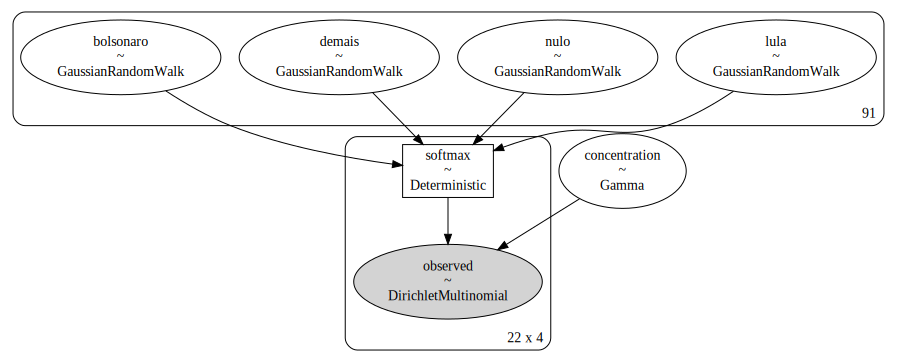

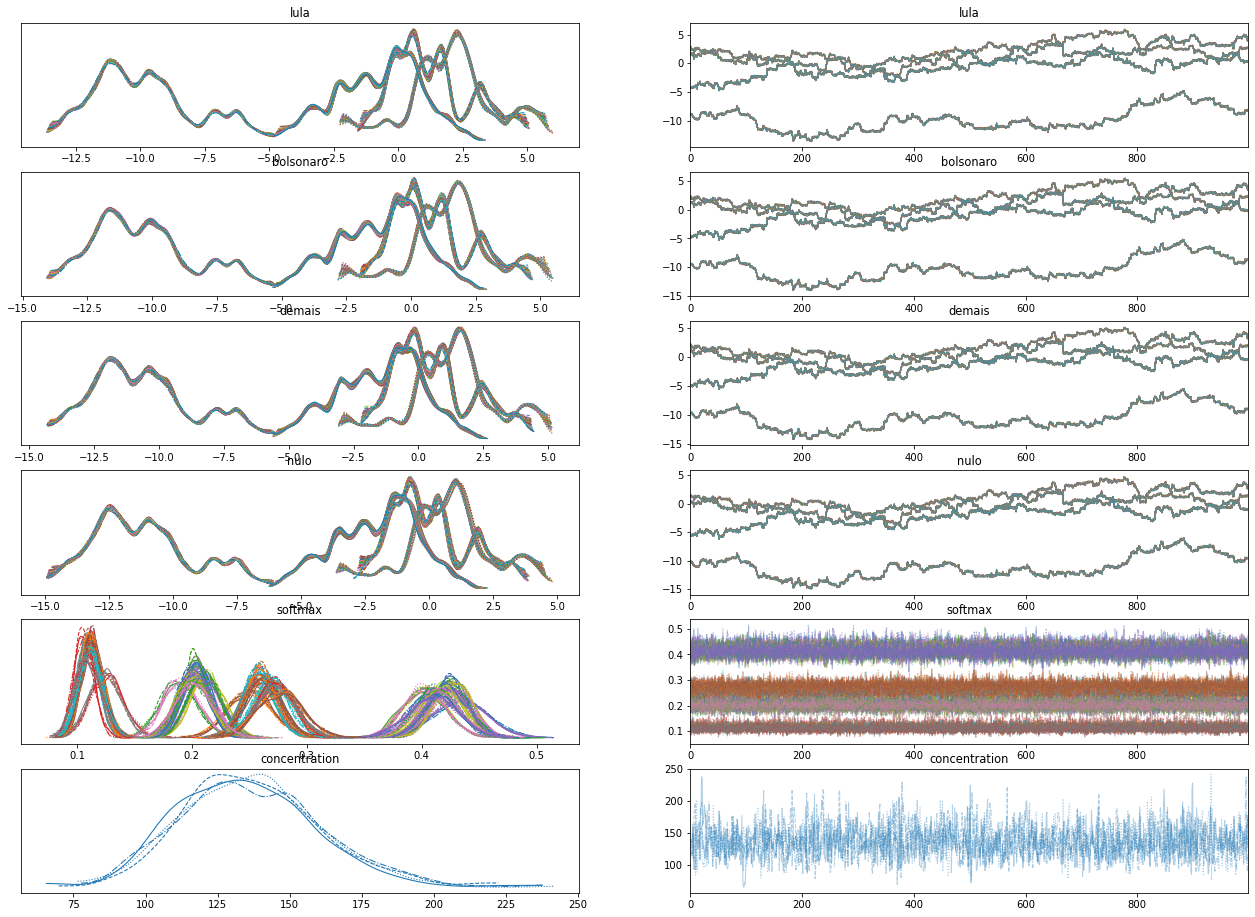

In [46]:
import theano.tensor as tt
from datetime import datetime

LULA = df.LULA.astype("int32")
BOLSONARO = df.BOLSONARO.astype("int32")
OUTROS = df.OUTROS.astype("int32")
NULO = df.NULO.astype("int32")
TOTAL = LULA + BOLSONARO + OUTROS + NULO

# inov = 0.025
inov = 0.025

with pm.Model() as grw:
    
    # inov = pm.HalfNormal('inov', sigma=0.15)
    
    # alpha = pm.Normal("alpha", shape=3)
    # baseline = pm.Normal("baseline", shape=(poll_day.shape[0], 3))
    
    grw_lula = pm.GaussianRandomWalk('lula', mu=0, sd=inov, shape=n_days)
    
    grw_bolsonaro = pm.GaussianRandomWalk('bolsonaro', mu=0, sd=inov, shape=n_days)
    
    grw_demais = pm.GaussianRandomWalk('demais', mu=0, sd=inov, shape=n_days)
    
    grw_nulo  = pm.GaussianRandomWalk('nulo', mu=0, sd=inov, shape=n_days)
    # grw  = pm.GaussianRandomWalk('grw', mu=0, sd=inov, shape=(n_days, 3))
    

    prob = pm.Deterministic("softmax", tt.nnet.softmax(tt.stack([grw_lula[poll_day], grw_bolsonaro[poll_day], grw_demais[poll_day], grw_nulo[poll_day]], axis=1)))
    # prior = tt.nnet.softmax(grw[poll_day])
    
    #conc  = pm.Uniform("concentration", lower=50, upper=250)
    conc = pm.Gamma("concentration", alpha=12, beta=0.075)
    
    pm.DirichletMultinomial('observed', n=TOTAL, a=prob * conc, observed=np.array([LULA.values, BOLSONARO.values, OUTROS.values, NULO.values]).T, shape=(poll_day.shape[0], 3))
    
    trace = pm.sample(1000, tune=30000, progressbar=True, return_inferencedata=True, chains=4, cores=4)

    summary = az.summary(trace) # used below
    az.plot_trace(trace, figsize=(22,16))  
print(datetime.now().strftime("%H:%M:%S"))
pm.model_to_graphviz(grw)

In [47]:
# baseline = trace.posterior.baseline.mean(axis=0)
L = trace.posterior.lula.mean(axis=0)
B = trace.posterior.bolsonaro.mean(axis=0)
D = trace.posterior.demais.mean(axis=0)
N = trace.posterior.nulo.mean(axis=0)
#IL = 
#print(baseline.shape)
TT = tt.stack([L,B,D,N], axis=1).eval()
print(TT.shape)
probs = []
#(baseline + tt.stack([L,D,N], axis=1).eval()[:,:,0]).shape
for i in range(n_days):
    probs.append(tt.nnet.softmax( TT[:,:,i]).eval())
probs = np.array(probs)
probs.shape

(1000, 4, 91)


(91, 1000, 4)

In [48]:
probs[:,:,:].mean(axis=1)

array([[0.43466883, 0.25029047, 0.18885485, 0.12618585],
       [0.43406014, 0.25084889, 0.18983402, 0.12525695],
       [0.43324661, 0.25134896, 0.1909728 , 0.12443163],
       [0.43112824, 0.25289151, 0.19236862, 0.12361163],
       [0.42878341, 0.25464324, 0.19387451, 0.12269884],
       [0.42645698, 0.25631584, 0.19537169, 0.1218555 ],
       [0.42422686, 0.25789345, 0.19689019, 0.12098951],
       [0.42191258, 0.25959421, 0.19842356, 0.12006965],
       [0.41950453, 0.26124036, 0.20003215, 0.11922296],
       [0.41707474, 0.26287198, 0.20163462, 0.11841866],
       [0.41472268, 0.26446426, 0.20321124, 0.11760182],
       [0.41257476, 0.26613861, 0.20458824, 0.11669839],
       [0.41014358, 0.26790393, 0.20604251, 0.11590998],
       [0.4077607 , 0.26950517, 0.20766348, 0.11507065],
       [0.40561015, 0.2710518 , 0.20913321, 0.11420484],
       [0.40340128, 0.27262745, 0.21070047, 0.11327081],
       [0.40258785, 0.27346508, 0.21183536, 0.11211171],
       [0.40262185, 0.27361281,

(3, 91, 4)


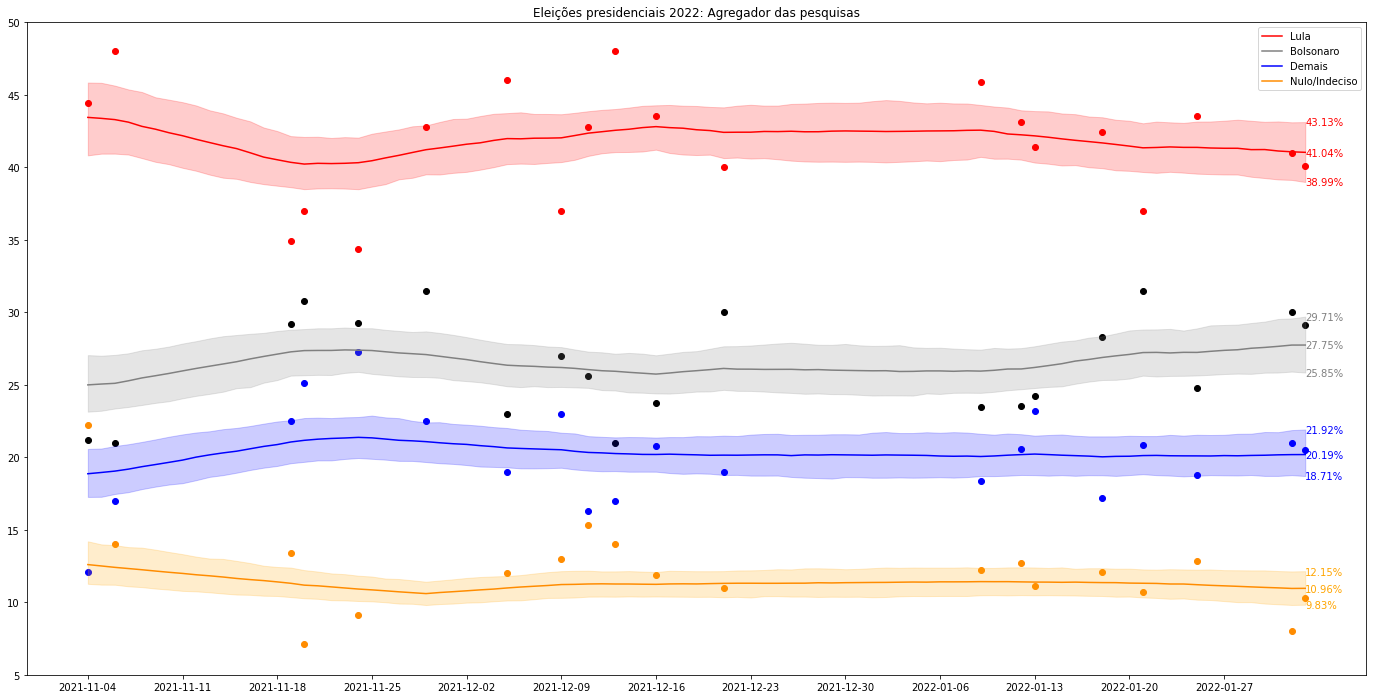

In [49]:
qs = np.quantile(probs[:,:,:], q=[0.025, 0.5, 0.975], axis=1)
print(qs.shape)
plt.figure(figsize=(24,12))
plt.ylim(5, 50)
L = np.zeros(n_days) * np.nan
B = L.copy()
O = L.copy()
N = L.copy()
L[poll_day.values] = 100.0 * df.LULA/df.TOTAL
B[poll_day.values] = 100.0 * df.BOLSONARO/df.TOTAL
O[poll_day.values] = 100.0 * df.OUTROS/df.TOTAL
N[poll_day.values] = 100.0 * df.NULO/df.TOTAL

def plot_final(idx, color):
    plt.text(datas[-1], qs[0,-1,idx]*100 - 0.25, f'{qs[0,-1,idx]*100:.2f}%', color=color);
    plt.text(datas[-1], qs[1,-1,idx]*100 - 0.25, f'{qs[1,-1,idx]*100:.2f}%', color=color);
    plt.text(datas[-1], qs[2,-1,idx]*100 - 0.25, f'{qs[2,-1,idx]*100:.2f}%', color=color);  


plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.scatter(datas, L, color='red')
plt.scatter(datas, B, color='black')
plt.scatter(datas, O, color='blue')
plt.scatter(datas, N, color='darkorange')
plt.plot(datas, qs[1,:,0]*100, color='red', label="Lula")
plt.plot(datas, qs[1,:,1]*100, color='gray', label="Bolsonaro")
plt.plot(datas, qs[1,:,2]*100, color='blue', label="Demais")
plt.plot(datas, qs[1,:,3]*100, color='darkorange', label="Nulo/Indeciso")
plt.fill_between(x=datas, y1=qs[0,:,0]*100., y2=qs[2,:,0]*100., alpha=0.2, color='red')
plt.fill_between(x=datas, y1=qs[0,:,1]*100., y2=qs[2,:,1]*100., alpha=0.2, color='gray')
plt.fill_between(x=datas, y1=qs[0,:,2]*100., y2=qs[2,:,2]*100., alpha=0.2, color='blue')
plt.fill_between(x=datas, y1=qs[0,:,3]*100., y2=qs[2,:,3]*100., alpha=0.2, color='orange')
plt.xticks([d for i,d in enumerate(datas) if i % 7 ==0]);
plt.legend(loc='best');
plot_final(0, 'red')
plot_final(1, 'gray')
plot_final(2, 'blue')
plot_final(3, 'orange')
#plt.text(datas[-1], qsL[1][-1]-.2, f'{qsL[1][-1]:.2f}%', color='red');
#plt.text(datas[-1], qsL[2][-1]-.2, f'{qsL[2][-1]:.2f}%', color='red');

In [50]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lula[0],-1.763,5.066,-11.561,5.042,2.436,1.854,5.0,19.0,2.35
lula[1],-1.764,5.066,-11.574,5.037,2.436,1.854,5.0,19.0,2.35
lula[2],-1.766,5.067,-11.582,5.021,2.436,1.854,5.0,19.0,2.35
lula[3],-1.771,5.067,-11.598,5.001,2.436,1.854,5.0,19.0,2.35
lula[4],-1.777,5.067,-11.581,5.016,2.436,1.854,5.0,19.0,2.35
lula[5],-1.783,5.068,-11.599,4.996,2.436,1.855,5.0,19.0,2.35
lula[6],-1.789,5.068,-11.627,4.984,2.436,1.854,5.0,18.0,2.35
lula[7],-1.794,5.068,-11.595,4.998,2.437,1.855,5.0,18.0,2.35
lula[8],-1.801,5.067,-11.677,4.929,2.436,1.854,5.0,18.0,2.35
lula[9],-1.807,5.067,-11.628,4.954,2.436,1.854,5.0,18.0,2.35
